# Librerias

In [1]:
# Importamos las librerias necesarias para el correcto funcionamiento del codigo
import nltk
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import random
import re
import string
import unicodedata
import pickle
from nltk.corpus import stopwords
from nltk import tokenize
from nltk.stem.snowball import SnowballStemmer
from nltk.tokenize import TweetTokenizer
from sklearn.svm import SVC

from sklearn.linear_model import LogisticRegression
from sklearn.model_selection import train_test_split
from sklearn.model_selection import learning_curve
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.preprocessing import LabelEncoder
from sklearn.metrics import accuracy_score

# Pre-procesamiento de datos

In [2]:
#Creamos una variable df con el dataset
df = pd.read_csv("haha_2021_train.csv")

In [3]:
df.drop(["votes_no","votes_1", "votes_2", "votes_3", "votes_4", "votes_5","humor_mechanism","humor_target"],
          axis=1,
          inplace=True)

In [4]:
nltk.download('stopwords')

[nltk_data] Downloading package stopwords to
[nltk_data]     C:\Users\luisz\AppData\Roaming\nltk_data...
[nltk_data]   Package stopwords is already up-to-date!


True

In [5]:
stop_words_sp = set(stopwords.words('spanish'))
stop_words_en = set(stopwords.words('english'))
#Concatenar las stopwords aplicándose a una cuenta que genera contenido en inglés y español
stop_words = stop_words_sp | stop_words_en

In [6]:
def LimpiarTexto(tweet):
    stopwords_english = stopwords.words('spanish')
    # remove stock market tickers like $GE
    tweet = re.sub(r'\$\w*', '', tweet)
    # quita el "RT"
    tweet = re.sub(r'^RT[\s]+', '', tweet) 
    # quita hyperlinks
    tweet = re.sub(r'https?:\/\/.*[\r\n]*', '', tweet) 
    # quita hashtags dejando la palabra sin el signo # 
    tweet = re.sub(r'#', '', tweet) 
    tweet = re.sub(r'[^\w\s]','',tweet) #Signos de puntuacion 
    tweet = tweet.lower() #Minusculas
    tweet = tweet.replace("ñ", "#") #Reemplaza 'ñ'
    tweet = unicodedata.normalize("NFKD", tweet)\
    .encode("ascii","ignore").decode("ascii")\
    .replace("#", "ñ") #Quita acentos
   
    eliminar_stopwords(tweet, stopwords_english)
 
    return tweet

def eliminar_stopwords(texto, stopwords):
    return ' '.join([word for word in texto.split(' ') if word not in stopwords])

def Tokenizacion(tweet):
  tokenizer = TweetTokenizer(preserve_case=False, strip_handles=True, reduce_len=True)
  tweet_tokens = tokenizer.tokenize(tweet)
  return tweet_tokens

def Stemming(tweet):
  stemmer = SnowballStemmer("spanish")
  tweets_clean = []
  for word in tweet:
      stem_word = stemmer.stem(word)  # stemming word
      tweets_clean.append(stem_word)

  return tweets_clean

In [7]:
df = df.assign(CleanText="",TokenizeText="", Text="")

In [8]:
for i in range(len(df)):
  df["CleanText"][i]  = LimpiarTexto(df['text'][i])
  df["TokenizeText"][i] = Tokenizacion(df['CleanText'][i])
  df["Text"][i] = Stemming(df['TokenizeText'][i])

df['TokenizeText'] = df.TokenizeText.astype(str)

C:\Users\luisz\AppData\Local\Temp\ipykernel_11528\2079637309.py:2: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df["CleanText"][i]  = LimpiarTexto(df['text'][i])
C:\Users\luisz\AppData\Local\Temp\ipykernel_11528\2079637309.py:3: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df["TokenizeText"][i] = Tokenizacion(df['CleanText'][i])
C:\Users\luisz\AppData\Local\Temp\ipykernel_11528\2079637309.py:4: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-

In [9]:
df = df.assign(Corpus="")

In [10]:
x = []
for i in range(len(df)):
  x ="".join(df['TokenizeText'][i])
  df["Corpus"][i] = x

C:\Users\luisz\AppData\Local\Temp\ipykernel_11528\1423334189.py:4: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df["Corpus"][i] = x


# Split Data

In [11]:
#Divide los datos en train y test
from sklearn.model_selection import train_test_split
y = df['is_humor']
x = df['Corpus']
train_x, test_x, train_y, test_y = train_test_split(x, y, test_size = 0.3)

In [12]:
Encoder = LabelEncoder()
Train_Y = Encoder.fit_transform(train_y)
Test_Y = Encoder.fit_transform(test_y)

# MLFlow

In [13]:
import mlflow
import mlflow.sklearn
track_uri = "http://localhost:5000/" # Esto puede ser que cambie por http://0.0.0.0:1234
mlflow.set_tracking_uri(track_uri)
mlflow.set_registry_uri("sqlite:////tmp/registry.db")


In [15]:
# Generando el experimento o cargandolo si existe
experiment_name = "Topicos"
mlflow.set_experiment(experiment_name)

# Cargando la información
client = mlflow.tracking.MlflowClient()
experiment_id = client.get_experiment_by_name(experiment_name).experiment_id


# Vamos a ver si es cierto
print(f"MLflow Version: {mlflow.__version__}")
print(f"Tracking URI: {mlflow.tracking.get_tracking_uri()}")
print(f"Nombre del experimento: {experiment_name}")
print(f"ID del experimento: {experiment_id}")

MLflow Version: 1.26.0
Tracking URI: http://localhost:5000/
Nombre del experimento: Topicos
ID del experimento: 1


In [16]:
mlflow.sklearn.autolog()
ngram_r = (1,2)
max_f = 100
Tfidf_vect = TfidfVectorizer(ngram_range=ngram_r, max_features=max_f)
Tfidf_vect.fit(df['Corpus'])
Train_X_Tfidf = Tfidf_vect.transform(train_x)
Test_X_Tfidf = Tfidf_vect.transform(test_x)
len(Tfidf_vect.vocabulary_)


with open('tfidf_vect.pkl', 'wb') as file:  
    pickle.dump(Tfidf_vect, file)

params = {'solver':'lbfgs'}
mlflow.log_params(params)
mlflow.log_artifact("tfidf_vect.pkl", "Vectores")
mlflow.log_metrics(
    {'ngram_param_1': ngram_r[0],'ngram_param_2':ngram_r[1] , 'max_features':max_f}
)

modelLogisticRegression = LogisticRegression(**params)

modelLogisticRegression.fit(Train_X_Tfidf,train_y)

# mlflow.sklearn.log_model(modelLogisticRegression, artifact_path="sklearn-model")

metrics = mlflow.sklearn.eval_and_log_metrics(modelLogisticRegression, Test_X_Tfidf, test_y, prefix="val_")

2022/05/20 02:21:44 WARNING mlflow.tracking.context.git_context: Failed to import Git (the Git executable is probably not on your PATH), so Git SHA is not available. Error: Failed to initialize: Bad git executable.
The git executable must be specified in one of the following ways:
    - be included in your $PATH
    - be set via $GIT_PYTHON_GIT_EXECUTABLE
    - explicitly set via git.refresh()

All git commands will error until this is rectified.

This initial warning can be silenced or aggravated in the future by setting the
$GIT_PYTHON_REFRESH environment variable. Use one of the following values:
    - quiet|q|silence|s|none|n|0: for no warning or exception
    - warn|w|warning|1: for a printed warning
    - error|e|raise|r|2: for a raised exception

Example:
    export GIT_PYTHON_REFRESH=quiet

2022/05/20 02:21:49 WARNING mlflow.utils.autologging_utils: MLflow autologging encountered a warning: "C:\Users\luisz\anaconda3\lib\site-packages\_distutils_hack\__init__.py:30: UserWarning:

In [17]:
X = 'Van dos ciegos y le dice uno al otro: -Ojala lloviera... -Ojala yo tambien...'
prediccion_X = Tfidf_vect.transform([X])
modelLogisticRegression.predict(prediccion_X)

array([1], dtype=int64)

2022/05/20 02:22:55 INFO mlflow.utils.autologging_utils: Created MLflow autologging run with ID 'c85ca7ea1cd94bf58fb6fa67f73f4ec2', which will track hyperparameters, performance metrics, model artifacts, and lineage information for the current sklearn workflow


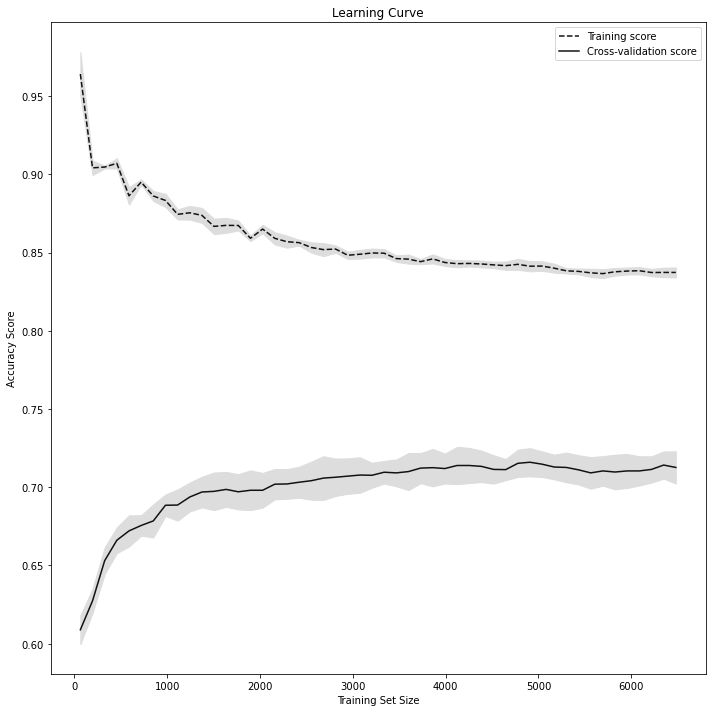

In [18]:
svc = SVC()

svc.fit(Train_X_Tfidf,train_y)

metrics = mlflow.sklearn.eval_and_log_metrics(svc, Test_X_Tfidf, test_y, prefix="val_")

prediccion_X = Tfidf_vect.transform([X])
svc.predict(prediccion_X)

train_sizes, train_scores, test_scores = learning_curve(svc, Test_X_Tfidf, test_y, cv=10, scoring='accuracy', n_jobs=-1, train_sizes=np.linspace(0.01, 1.0, 50))

train_mean = np.mean(train_scores, axis=1)
train_std = np.std(train_scores, axis=1)

test_mean = np.mean(test_scores, axis=1)
test_std = np.std(test_scores, axis=1)

plt.subplots(1, figsize=(10,10))
plt.plot(train_sizes, train_mean, '--', color="#111111",  label="Training score")
plt.plot(train_sizes, test_mean, color="#111111", label="Cross-validation score")

plt.fill_between(train_sizes, train_mean - train_std, train_mean + train_std, color="#DDDDDD")
plt.fill_between(train_sizes, test_mean - test_std, test_mean + test_std, color="#DDDDDD")

plt.title("Learning Curve")
plt.xlabel("Training Set Size"), plt.ylabel("Accuracy Score"), plt.legend(loc="best")
plt.tight_layout()
plt.show()

2022/05/20 02:32:00 INFO mlflow.utils.autologging_utils: Created MLflow autologging run with ID 'b6ea7f67ac8d47cabcdf6fccb8116b2c', which will track hyperparameters, performance metrics, model artifacts, and lineage information for the current sklearn workflow


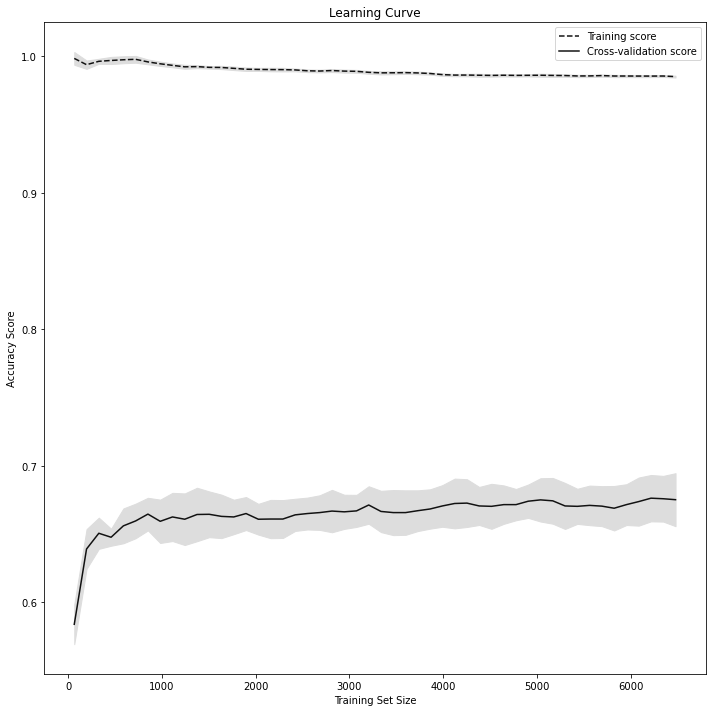

In [20]:
svc=SVC(C=100.0) 

svc.fit(Train_X_Tfidf,train_y)

metrics = mlflow.sklearn.eval_and_log_metrics(svc, Test_X_Tfidf, test_y, prefix="val_")

prediccion_X = Tfidf_vect.transform([X])
svc.predict(prediccion_X)

train_sizes, train_scores, test_scores = learning_curve(svc, Test_X_Tfidf, test_y, cv=10, scoring='accuracy', n_jobs=-1, train_sizes=np.linspace(0.01, 1.0, 50))

train_mean = np.mean(train_scores, axis=1)
train_std = np.std(train_scores, axis=1)

test_mean = np.mean(test_scores, axis=1)
test_std = np.std(test_scores, axis=1)

plt.subplots(1, figsize=(10,10))
plt.plot(train_sizes, train_mean, '--', color="#111111",  label="Training score")
plt.plot(train_sizes, test_mean, color="#111111", label="Cross-validation score")

plt.fill_between(train_sizes, train_mean - train_std, train_mean + train_std, color="#DDDDDD")
plt.fill_between(train_sizes, test_mean - test_std, test_mean + test_std, color="#DDDDDD")

plt.title("Learning Curve")
plt.xlabel("Training Set Size"), plt.ylabel("Accuracy Score"), plt.legend(loc="best")
plt.tight_layout()
plt.show()

In [ ]:
svc=SVC(C=1000.0) 

svc.fit(Train_X_Tfidf,train_y)

metrics = mlflow.sklearn.eval_and_log_metrics(svc, Test_X_Tfidf, test_y, prefix="val_")

prediccion_X = Tfidf_vect.transform([X])
svc.predict(prediccion_X)

2022/05/20 02:43:06 INFO mlflow.utils.autologging_utils: Created MLflow autologging run with ID '5be11489b7364d2b9bc7ec95a2c4455b', which will track hyperparameters, performance metrics, model artifacts, and lineage information for the current sklearn workflow


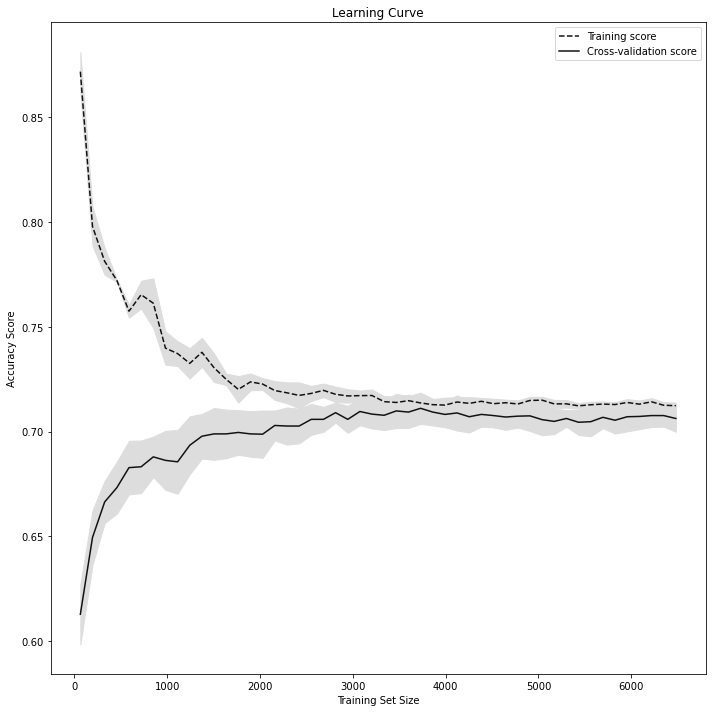

In [22]:
linear_svc=SVC(kernel = 'linear', C=1.0) 

linear_svc.fit(Train_X_Tfidf,train_y)

metrics = mlflow.sklearn.eval_and_log_metrics(linear_svc, Test_X_Tfidf, test_y, prefix="val_")

prediccion_X = Tfidf_vect.transform([X])
linear_svc.predict(prediccion_X)

train_sizes, train_scores, test_scores = learning_curve(linear_svc, Test_X_Tfidf, test_y, cv=10, scoring='accuracy', n_jobs=-1, train_sizes=np.linspace(0.01, 1.0, 50))

train_mean = np.mean(train_scores, axis=1)
train_std = np.std(train_scores, axis=1)

test_mean = np.mean(test_scores, axis=1)
test_std = np.std(test_scores, axis=1)

plt.subplots(1, figsize=(10,10))
plt.plot(train_sizes, train_mean, '--', color="#111111",  label="Training score")
plt.plot(train_sizes, test_mean, color="#111111", label="Cross-validation score")

plt.fill_between(train_sizes, train_mean - train_std, train_mean + train_std, color="#DDDDDD")
plt.fill_between(train_sizes, test_mean - test_std, test_mean + test_std, color="#DDDDDD")

plt.title("Learning Curve")
plt.xlabel("Training Set Size"), plt.ylabel("Accuracy Score"), plt.legend(loc="best")
plt.tight_layout()
plt.show()

mlflow.end_run()

2022/05/20 02:52:59 INFO mlflow.utils.autologging_utils: Created MLflow autologging run with ID '69f07a2de2414f5f9996825d1292eb86', which will track hyperparameters, performance metrics, model artifacts, and lineage information for the current sklearn workflow


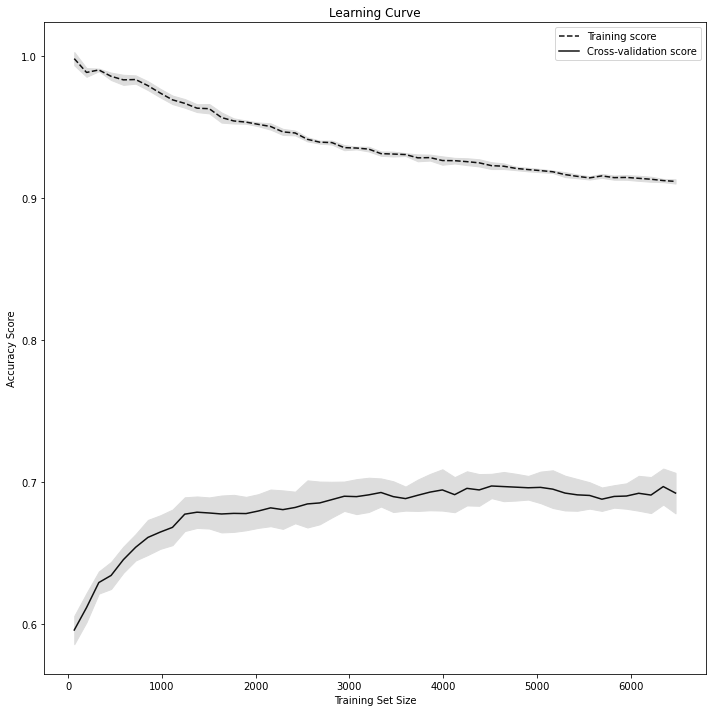

In [24]:
poly_svc=SVC(kernel = 'poly', C=1.0) 

poly_svc.fit(Train_X_Tfidf,train_y)

metrics = mlflow.sklearn.eval_and_log_metrics(poly_svc, Test_X_Tfidf, test_y, prefix="val_")

prediccion_X = Tfidf_vect.transform([X])
linear_svc.predict(prediccion_X)

train_sizes, train_scores, test_scores = learning_curve(poly_svc, Test_X_Tfidf, test_y, cv=10, scoring='accuracy', n_jobs=-1, train_sizes=np.linspace(0.01, 1.0, 50))

train_mean = np.mean(train_scores, axis=1)
train_std = np.std(train_scores, axis=1)

test_mean = np.mean(test_scores, axis=1)
test_std = np.std(test_scores, axis=1)

plt.subplots(1, figsize=(10,10))
plt.plot(train_sizes, train_mean, '--', color="#111111",  label="Training score")
plt.plot(train_sizes, test_mean, color="#111111", label="Cross-validation score")

plt.fill_between(train_sizes, train_mean - train_std, train_mean + train_std, color="#DDDDDD")
plt.fill_between(train_sizes, test_mean - test_std, test_mean + test_std, color="#DDDDDD")

plt.title("Learning Curve")
plt.xlabel("Training Set Size"), plt.ylabel("Accuracy Score"), plt.legend(loc="best")
plt.tight_layout()
plt.show()

mlflow.end_run()